# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_

In [1]:
#libraries and packages
!pip install torch
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [5]:
#load data
df = pd.read_csv('processed_data.csv')
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

#reset index
df.set_index('id', inplace = True)

In [6]:
#preview
df.head()

,sentiment,text
id,,
0,Irrelevant,mentioned facebook struggling motivation go ru...
1,Neutral,bbc news amazon bos jeff bezos reject claim co...
2,Negative,microsoft pay word function poorly samsungus c...
3,Negative,csgo matchmaking full closet hacking truly awf...
4,Neutral,president slapping american face really commit...


In [7]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57694 entries, 0 to 57
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  57693 non-null  object
 1   text       56448 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [8]:
#check for null
df.dropna(inplace=True)
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [9]:
#look at an example
df.text.iloc[11]

'itching assassinate tccgif assassinscreedblackflag assassinscreed thecapturedcollective pictwittercomvv8mogtcjw'

In [10]:
#count for each class
df.sentiment.value_counts()

Positive      16517
Negative      16127
Neutral       13296
Irrelevant    10508
Name: sentiment, dtype: int64

In [11]:
#drop irrelevent class
df = df[~df.sentiment.str.contains('\|')]

In [12]:
#drop irrelevent class
df = df[df.sentiment != 'nocode']

In [13]:
#final classes
df.sentiment.value_counts()

Positive      16517
Negative      16127
Neutral       13296
Irrelevant    10508
Name: sentiment, dtype: int64

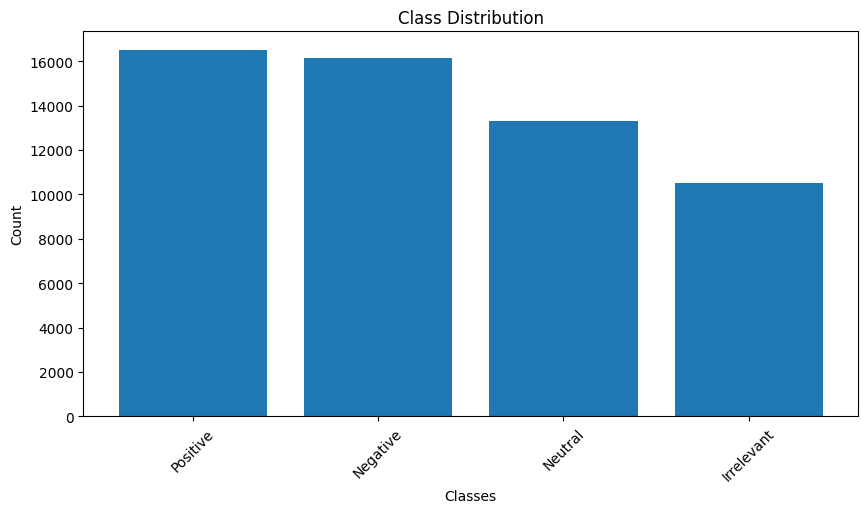

In [14]:
import matplotlib.pyplot as plt
# Count the occurrences of each class
class_counts = df['sentiment'].value_counts()

# Get class labels and their counts
class_labels = class_counts.index
class_values = class_counts.values

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

In [15]:
#store classes into an array
possible_labels = df.sentiment.unique()
possible_labels

array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object)

In [16]:
#convert labels into numeric values
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [17]:
label_dict

{'Irrelevant': 0, 'Neutral': 1, 'Negative': 2, 'Positive': 3}

In [18]:
#convert labels into numeric values
df['label'] = df.sentiment.replace(label_dict)
df.head(10)

,sentiment,text,label
id,,,
0,Irrelevant,mentioned facebook struggling motivation go ru...,0
1,Neutral,bbc news amazon bos jeff bezos reject claim co...,1
2,Negative,microsoft pay word function poorly samsungus c...,2
3,Negative,csgo matchmaking full closet hacking truly awf...,2
4,Neutral,president slapping american face really commit...,1
5,Negative,hi eahelp ’ madeleine mccann cellar past 13 ye...,2
6,Positive,thank eamaddennfl new te austin hooper orange ...,3
7,Positive,rocket league sea thief rainbow six siege🤔 lov...,3
8,Positive,as still kneedeep assassin creed odyssey way a...,3


In [ ]:
#find the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

In [ ]:
# Define the maximum allowed length
max_length = 260

# Filter the DataFrame to keep only rows where the length of "text" is less than or equal to max_length
df = df[df['text'].str.len() <= max_length]

# Reset the index if you want continuous row indices
df.reset_index(drop=True, inplace=True)

In [ ]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
#find the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [ ]:
#create new column
df['data_type'] = 'not_set'
df.head()

In [ ]:
#fill in data type
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['sentiment', 'label', 'data_type']).count()

## Tokenization

In [ ]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
#load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [ ]:
#tokenize train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#tokenizer val set
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [ ]:
encoded_data_train

## Encoding

In [ ]:
#encode train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

In [ ]:
#encode val set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

#convert data type to torch.tensor
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [ ]:
input_ids_train

In [ ]:
attention_masks_train

In [ ]:
labels_train

In [ ]:
#create dataloader
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                             attention_masks_val,
                             labels_val)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

In [ ]:
dataset_train

In [ ]:
dataset_train.tensors

## Set Up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

In [ ]:
#model summary
model.config

## Create Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #since we have limited resource

#load train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#load val set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

## Set Up Optimizer and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 6

#load optimizer
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5

In [ ]:
#load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

## Define Performance Metrics

In [ ]:
#preds = [0.9 0.05 0.05 0 0 0]
#preds = [1 0 0 0 0 0]

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):

    #evaluation mode disables the dropout layer
    model.eval()

    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

## Train Model

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0

    #set up progress bar
    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()

        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write('\nEpoch {epoch}')

    #print training result
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    #evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

## Model Evaluation


In [ ]:
outputs.loss

In [ ]:
outputs.logits

In [ ]:
#save model
model.to(device)
pass

In [ ]:
#evaluate
_, predictions, true_vals = evaluate(dataloader_val)

In [ ]:
#get accuracy score
accuracy_per_class(predictions, true_vals)